In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt

#custom Kothadekh
from data_dataloader import get_loaders
from data_dekhabet import convertTokens2Dekhabet

# Bi-LSTM Component

In [43]:
#Bi-LSTM borrowed fom https://github.com/meijieru/crnn.pytorch/blob/master/models/crnn.py
class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()

        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)

    def forward(self, input):
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)

        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)

        return output

# R-CNN Component

In [46]:
class R_CNN(nn.Module):

    def __init__(self, train=True):
        super(R_CNN, self).__init__()

        in_nc = 3
        nf = 64
        hdn = 256
        nclass = 22 #dekhabet class
        
        
        # custom vesion of the CNN poposed 
        # here: https://arxiv.org/pdf/1507.05717.pdf
        self.convs = nn.Sequential(
            
            nn.Conv2d(in_nc, nf, 3, 1, 1),                                                                                                                 
            nn.LeakyReLU(0.2, True),
            nn.MaxPool2d(2, 2), 
            
            nn.Conv2d(nf, nf*2, 3, 1, 1), 
            nn.LeakyReLU(0.2, True),
            nn.MaxPool2d(2,2), 
            
            nn.Conv2d(nf*2, nf*4, 3, 1, 1), 
            nn.BatchNorm2d(nf*4),
            
            nn.Conv2d(nf*4, nf*4, 3, 1, 1), 
            nn.LeakyReLU(0.2, True),
            nn.MaxPool2d((2,1),(2,1)), 
            
            
            nn.Conv2d(nf*4, nf*4, 3, 1, 1), 
            nn.LeakyReLU(0.2, True),
            nn.MaxPool2d((1,21),(2,1)),
            
            
            nn.Conv2d(nf*4, nf*8, 3, 1, 1), 
            nn.BatchNorm2d(nf*8),
            
            
            nn.Conv2d(nf*8, nf*8, 3, 1, 1), 
            nn.LeakyReLU(0.2, True),
            nn.MaxPool2d((2,1),(2,1)),
            
            
            nn.Conv2d(nf*8, nf*8, 3, 1, 1), 
            nn.LeakyReLU(0.2, True),
            nn.MaxPool2d((2, 1),(2,1)),  
            
            nn.Conv2d(nf*8, nf*8, 2, 1,0), 
            
            
        )
        
        self.bilstm = nn.Sequential(
                        BidirectionalLSTM(nf*8, hdn, hdn),
                        BidirectionalLSTM(hdn, hdn, nclass),
                    )
        
        self.lgsftMx = nn.LogSoftmax(dim=2)
        self.sftMx = nn.Softmax(dim=2)
        
    def forward(self, x):

        out = self.convs(x)
        out = out.squeeze(2)
        out = out.permute(2, 0, 1) #ctc expects [width,batch,label]
        
        
        out = self.bilstm(out)
        
        if(self.train):
            out = self.lgsftMx(out)
        else:
            out = self.sftMx(out)
            
        
        
        return out


# Initiate Model And Loss

In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = R_CNN()
model = model.to(device)

criterion = nn.CTCLoss().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.5, 0.999))

optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001)


cuda:0


# Getting The Data

In [20]:
batch_size= 25

path = '2k2sec_22class'
trainloader, validloader = get_loaders(path,split_perc=0.8,batch_size=batch_size)

total_step = len(trainloader)
trainiter = iter(trainloader)

2000 images from the dataset
1600 400


# Training

In [11]:
ctc_loss_list = []
acc_list = []

num_epochs = 2500


In [13]:

for epoch in range(num_epochs):
    
    trainiter = iter(trainloader)
    
    for i in range(total_step):
        
        spectros, lbls, lbl_lens = trainiter.next()
        
        spectros = spectros.to(device)
        lbls = lbls.to(device)
        lbl_lens.to(device)
        
        pred = model(spectros)
        preds_size = Variable(torch.LongTensor([pred.size(0)] * batch_size))
        
        #backprop and optimize!
        
        
        optimizer.zero_grad()
        cost = criterion(pred, lbls, preds_size, lbl_lens)/batch_size

        cost.backward()
        optimizer.step()
        
      
    if (epoch+1) % 10 == 0:
        print('Epoch No [{}/{}]  {:.4f}'.format(epoch+1,num_epochs,cost.item()))
        ctc_loss_list.append(cost.item())

    if (epoch+1) % 100 == 0:
        print('Epoch No {}  reached saving model'.format(epoch+1))
        torch.save(model.state_dict(), 'outputModel/KDNet_epoch_rmsProp_{}.pkl'.format(epoch+1))

Epoch No [10/2500]  0.0903
Epoch No [20/2500]  0.0724
Epoch No [30/2500]  0.0591
Epoch No [40/2500]  0.0464
Epoch No [50/2500]  0.0381
Epoch No [60/2500]  0.0254
Epoch No [70/2500]  0.0180
Epoch No [80/2500]  0.0155
Epoch No [90/2500]  0.0060
Epoch No [100/2500]  0.0036
Epoch No 100  reached saving model
Epoch No [110/2500]  0.0009
Epoch No [120/2500]  -0.0033
Epoch No [130/2500]  -0.0057
Epoch No [140/2500]  -0.0059
Epoch No [150/2500]  -0.0084
Epoch No [160/2500]  -0.0093
Epoch No [170/2500]  -0.0105
Epoch No [180/2500]  -0.0105
Epoch No [190/2500]  -0.0126
Epoch No [200/2500]  -0.0128
Epoch No 200  reached saving model
Epoch No [210/2500]  -0.0091
Epoch No [220/2500]  0.0105
Epoch No [230/2500]  -0.0131
Epoch No [240/2500]  -0.0140
Epoch No [250/2500]  -0.0129
Epoch No [260/2500]  -0.0121
Epoch No [270/2500]  -0.0131
Epoch No [280/2500]  -0.0131
Epoch No [290/2500]  -0.0138
Epoch No [300/2500]  -0.0103
Epoch No 300  reached saving model
Epoch No [310/2500]  -0.0130
Epoch No [320/250

KeyboardInterrupt: 

# Running Inference

In [47]:
inferModel = R_CNN()
inferModel.load_state_dict(torch.load('outputModel/KDNet_epoch_rmsProp_800.pkl'))
inferModel.to(device)

R_CNN(
  (convs): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): LeakyReLU(negative_slope=0.2, inplace)
    (10): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.2, inplace)
    (13): MaxPool2d(kernel_size=(1, 21), s

In [36]:
testIter = iter(validloader)
spectros, lbls, lbl_lens = testIter.next()

spectros = spectros.to(device)
lbls = lbls.to(device)
lbl_lens.to(device)

tensor([32, 25, 27,  8, 19, 10, 20, 13, 24, 30, 10, 17, 35, 20, 26,  8, 31, 32,
        23, 17, 22, 12, 14, 16, 24], device='cuda:0')

In [37]:
preds = inferModel(spectros)
_, preds = preds.max(2)
preds = preds.transpose(1, 0)

print(preds)
print(lbls)



tensor([[ 1,  7, 15,  ...,  4,  8,  2],
        [10,  1,  3,  ..., 16,  8,  2],
        [21,  2, 21,  ...,  2, 15,  3],
        ...,
        [20,  9,  4,  ...,  8,  2, 15],
        [ 1, 14,  3,  ...,  0, 15,  1],
        [21,  3, 16,  ...,  0, 15,  1]], device='cuda:0')
tensor([[ 1,  7, 15,  ...,  0,  0,  0],
        [10,  1,  3,  ...,  0,  0,  0],
        [21,  2, 21,  ...,  0,  0,  0],
        ...,
        [20,  9,  4,  ...,  0,  0,  0],
        [ 1, 14,  3,  ...,  0,  0,  0],
        [21,  3, 16,  ...,  0,  0,  0]], device='cuda:0')


In [35]:
print('Our prediction labels: ')

for sent in preds:
    print(convertTokens2Dekhabet(sent))


print('\n\nBelow is the Actual labels: ')
    
    
for sent in lbls:
    print(convertTokens2Dekhabet(sent))

Our prediction labels: 
apnaner     shobaike   thanae   jeete   hobe
sai kollo   jisstrra    boltte        parbe
shesh    porjj   jonto    jigg  gesh    koreni
ni              uuiieee                oork
kin       ei                           thae
cha        a aar                        ktaa
dhon  noo  badd       jamman           bhai
ja                hobbab               hobe
rahaa        kore  er     k   chhie     chhar
ami    tate     kono   shomosh sha    dekhi na
ei                    to              am mu
kake           khun               korreechhe
jori   janala   bonddho kore  uthe   daralo
ke         kor         shshsh  sho         enish
ekhono     jani     na      keno     eshechhe
bish                   ta               kaaa
benjar  kk oo ho    kooroo  o rhoon doo  mo
munar     jon ne  tar   khub  maea   lagchhe
majhe          majjhe      halka     narunn
bei       ooli         aa            mchchchhe
ghorita     oi      manuu    sher       deaa
ki          bollll    li    

# Accuracy Calc

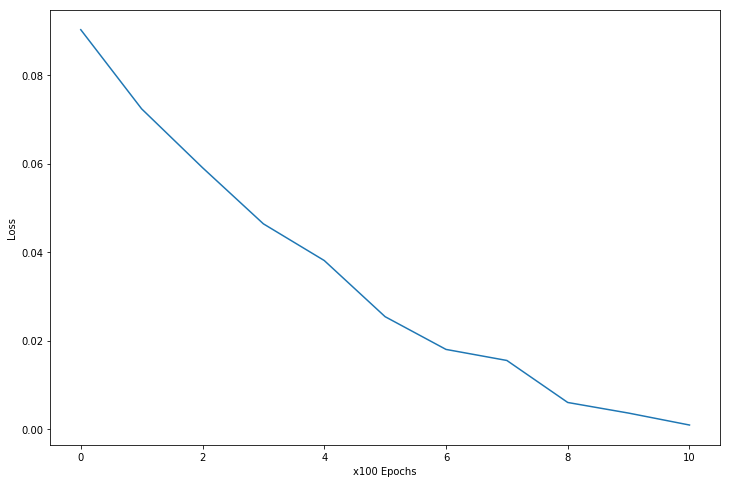

In [27]:
lst = [0.0903, 0.0724, 0.0591, 0.0464, 0.0381, 0.0254, 0.0180, 0.0155,0.0060,0.0036,0.0009]


plt.figure(figsize=[12,8])


plt.ylabel('Loss')
plt.xlabel('x100 Epochs')

plt.plot(lst)